In [1]:
import os
import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt

from tqdm import tqdm
from forcing_functions import get_function

# Set the random seed so that results are consistent across trials
torch.manual_seed(123)

# Creating The SIREN Class
The SIREN network is described in [this paper](https://arxiv.org/abs/2006.09661)

The main points from the paper that will be used here are:
- Neural networks are functions of the form $u(x) = l_N \circ l_{N-1} \circ \cdots \circ l_1$ 
  - Each $l_i$ is a function representing a layer of the network
  - $N$ is the number of layers in the network
  - The layers take the form $l_i(x) = a( W_i x + b_i )$
    - $a$ is the activation function (in this case $a(x) = \sin (\omega_0 x)$, where $\omega_0$ is a hyper-parameter)

SIRENs are especially good at handling differentiation of the network with respect to its input. This is because
$$\frac{d}{dx}\sin(x) = \cos(x) = \sin\left(\frac{\pi}{2}-x\right)$$

In [2]:
# Define the layers l_1 ... l_(N-1). l_N is just a linear layer, Wx + b
class SineLayer(nn.Module):
    """
    Adapted from
    https://github.com/vsitzmann/siren/blob/master/explore_siren.ipynb
    """

    def __init__(
        self, in_features, out_features, bias=True, is_first=False, omega_0=30
    ):
        super().__init__()
        self.omega_0 = omega_0
        self.is_first = is_first

        self.in_features = in_features
        self.linear = nn.Linear(in_features, out_features, bias=bias)

        self.init_weights()

    def init_weights(self):
        with torch.no_grad():
            if self.is_first:
                self.linear.weight.uniform_(-1 / self.in_features, 1 / self.in_features)
            else:
                self.linear.weight.uniform_(
                    -np.sqrt(6 / self.in_features) / self.omega_0,
                    np.sqrt(6 / self.in_features) / self.omega_0,
                )

    def forward(self, input):
        return torch.sin(self.omega_0 * self.linear(input))


# Define the SIREN network
class Siren(nn.Module):
    """
    Adapted from
    https://github.com/vsitzmann/siren/blob/master/explore_siren.ipynb
    """

    def __init__(
        self,
        in_features,
        hidden_features,
        hidden_layers,
        out_features,
        outermost_linear=False,
        first_omega_0=30,
        hidden_omega_0=30.0,
    ):
        super().__init__()

        self.net = []
        self.net.append(
            SineLayer(
                in_features, hidden_features, is_first=True, omega_0=first_omega_0
            )
        )

        for i in range(hidden_layers):
            self.net.append(
                SineLayer(
                    hidden_features,
                    hidden_features,
                    is_first=False,
                    omega_0=hidden_omega_0,
                )
            )

        if outermost_linear:
            final_linear = nn.Linear(hidden_features, out_features)

            with torch.no_grad():
                final_linear.weight.uniform_(
                    -np.sqrt(6 / hidden_features) / hidden_omega_0,
                    np.sqrt(6 / hidden_features) / hidden_omega_0,
                )

            self.net.append(final_linear)
        else:
            self.net.append(
                SineLayer(
                    hidden_features,
                    out_features,
                    is_first=False,
                    omega_0=hidden_omega_0,
                )
            )

        self.net = nn.Sequential(*self.net)

    def forward(self, coords):
        coords = (
            coords.clone().detach().requires_grad_(True)
        )  # allows to take derivative w.r.t. input
        output = self.net(coords)

        return output, coords


class OtherActivationNetwork(nn.Module):
    def __init__(
        self,
        in_features,
        hidden_features,
        hidden_layers,
        out_features,
        outermost_linear=False,
        activation=nn.Tanh,
    ):
        super().__init__()
        self.activation = activation

        self.net = []
        self.net.append(
            nn.Sequential(nn.Linear(in_features, hidden_features), self.activation())
        )

        for _ in range(hidden_layers):
            self.net.append(
                nn.Sequential(
                    nn.Linear(
                        hidden_features,
                        hidden_features,
                    ),
                    self.activation(),
                )
            )

        if outermost_linear:
            final_linear = nn.Linear(hidden_features, out_features)
            self.net.append(final_linear)
        else:
            self.net.append(
                nn.Sequential(
                    nn.Linear(hidden_features, out_features), self.activation()
                )
            )

        self.net = nn.Sequential(*self.net)

    def forward(self, coords):
        coords = (
            coords.clone().detach().requires_grad_(True)
        )  # allows to take derivative w.r.t. input
        output = self.net(coords)

        return output, coords


def gradient(y, x, grad_outputs=None):
    if grad_outputs is None:
        grad_outputs = torch.ones_like(y)
    grad = torch.autograd.grad(y, [x], grad_outputs=grad_outputs, create_graph=True)[0]
    return grad

# The Problem
A spring-mass system obeys the following second-order linear ordinary differential equation
$$m\ddot{u} + c\dot{u} + ku = f(t)$$
where $u(t)$ is the position of the mass along the axis of the spring and $f(t)$ is the force applied to the spring

We know that
$$ \begin{cases} u(0) = 0 \\ \dot{u}(0) = 0 \end{cases} $$

For this experiment, we will take
$$ \begin{cases} m = 5 \\ c = 10 \\ k = 80 \\ f(t) = 10\cos\left( 5\pi t \right) \end{cases} $$
These are arbitrary and can be changed easily. The solution will be sought on the interval $t\in\left[0, 2.9\right]$


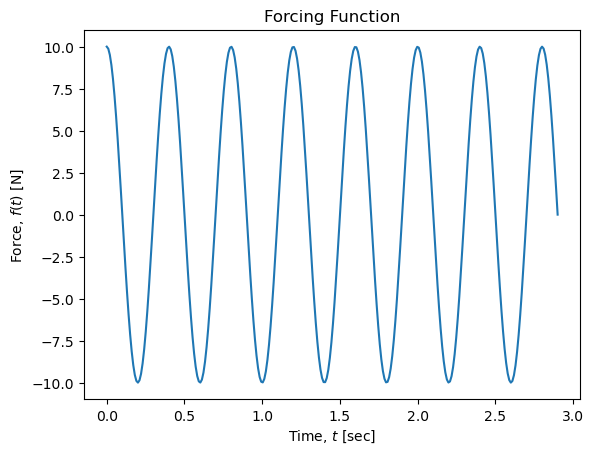

In [3]:
INITIAL_TIME = 0
FINAL_TIME = 2.9
N_TIMESTEPS = 290

M = 5
C = 10
K = 80

DT = (FINAL_TIME - INITIAL_TIME) / N_TIMESTEPS

t = torch.linspace(INITIAL_TIME, FINAL_TIME, N_TIMESTEPS, device="cuda")
f = lambda t: 10 * torch.cos(5 * torch.pi * t)

plt.plot(t.cpu(), f(t).cpu().flatten())
plt.xlabel("Time, $t$ [sec]")
plt.ylabel("Force, $f(t)$ [N]")
plt.title("Forcing Function");

# RK Method Definition
The Runge-Kutta (RK) method allows us to find an approximate temporal evaluation of a dynamical system described by a system of ODEs:

$$\frac{d}{dx}\mathbf{z} = \mathbf{f}\left(t, \mathbf{z}(t);\lambda\right)$$

where $\mathbf{z}(t)$ is the solution function and $\mathbf{f}(t; \lambda)$ is a differential operator parametrized by $\lambda$. The general RK scheme for a time-step $\Delta t$ is given by

$$
\mathbf{h}^k = \mathbf{f}\left( t_0 + \gamma^k\Delta t, \mathbf{z}^0 + \Delta t \sum_{l=1}^s \alpha^{kl} \mathbf{h}^l; \lambda \right)\ ,\ k = 1,\cdots,s
$$
$$
\mathbf{z}^1 = \mathbf{z}^0 + \Delta t \sum_{k=1}^s \beta^k\mathbf{h}^k
$$

where
- $t_0$ is the current time
- $\mathbf{z}^0$ is the current state of the dynamical system
- $\gamma^k$, $\alpha^{kl}$, and $\beta^k$ are coefficients which define the RK scheme to be used
- $\Delta t$ is the time-step size
- $\lambda$ are the parameters of the differential operator
- $\mathbf{h}^k$ are the intermediate RK state-update vectors
- $\mathbf{z}^1$ is the next state of the dynamical system

For the sake of this experiment, a standard 4th order RK explicit integration scheme is employed:
$$
    \mathbf{\alpha} = 
    \begin{bmatrix}
            &     &   &   \\
        1/2 &     &   &   \\
            & 1/2 &   &   \\
            &     & 1 &   \\
    \end{bmatrix}
$$

$$
    \mathbf{\beta} = 
    \frac{1}{6}
    \begin{bmatrix}
        1 & 2 & 2 & 1
    \end{bmatrix}
$$

$$
    \mathbf{\gamma} = 
    \begin{bmatrix}
        0 & 1/2 & 1/2 & 1
    \end{bmatrix}
$$

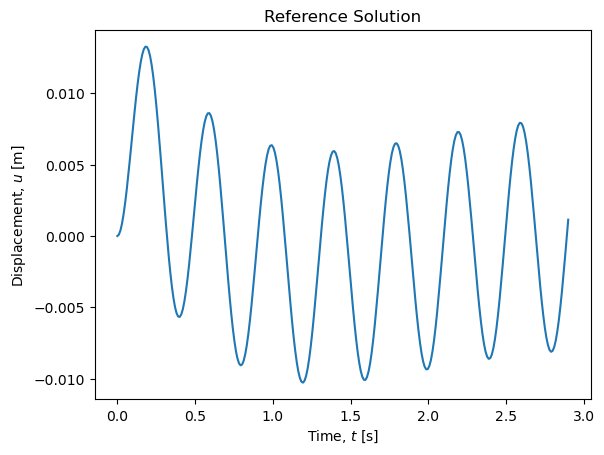

In [4]:
# Define the differential operator (`f` above)
def diff(t, z):
    """Differential operator used in Runge-Kutta method

    Args:
        t (torch.Tensor): time, 0d tensor
        z (torch.Tensor): state vector, 1x2 tensor of the form
            z = [[u, u_t]]
    """

    A = 1 / M * torch.as_tensor([[0, 1], [-K, -C]], device="cuda")
    F = torch.as_tensor([[0], [f(t)]], device="cuda")

    Z_T = A @ z.T + F
    return Z_T.T


# Define RK scheme hyperparameters
alpha = torch.zeros(4, 4, device="cuda")
alpha[1, 0], alpha[2, 1], alpha[3, 2] = 1 / 2, 1 / 2, 1

beta = 1 / 6 * torch.as_tensor([1, 2, 2, 1], device="cuda").reshape(1, -1)
gamma = torch.as_tensor([0, 1 / 2, 1 / 2, 1], device="cuda")


def get_h_vector_RK(t0, z0, gamma, dt, alpha, diff):
    """Get the update h-vector from the current state. Note that this implementation only works for explicit RK schemes (alpha is strictly lower-triangular)

    Args:
        t0 (torch.Tensor): current time (0d float tensor)
        gamma (torch.Tensor): RK time-step weights
        dt (torch.Tensor): time-step size
        z0 (torch.Tensor): current state
        alpha (torch.Tensor): state-vector weight matrix
        diff (Callable: [torch.Tensor, torch.Tensor] -> torch.Tensor): differential operator of the dynamical system

    Returns:
        torch.Tensor: h-vector used to update the system state
    """
    h_vector = torch.zeros(4, 2, device="cuda")

    for i in range(len(h_vector)):
        h_vector[i, :] = diff(t0 + gamma[i] * dt, z0 + dt * alpha[i].reshape(1, -1) @ h_vector)
    return h_vector


def update_state(z0, dt, beta, h_vector):
    """Use the RK method to get the next state from the current update h-vector

    Args:
        z0 (torch.Tensor): current state (1 x 2 tensor)
        dt (torch.Tensor): time-step size (0d float tensor)
        beta (torch.Tensor): intermediate state vector weights (4 x 1 tensor)
        h_vector (torch.Tensor): matrix of all state vectors (4 X 2N tensor)

    Returns:
        torch.Tensor: next state (1x2 tensor)
    """

    z1 = z0 + dt * beta @ h_vector
    return z1


# Test it out
z = torch.zeros(len(t), 2, device="cuda")

for i in range(1, len(t)):
    dt = t[i] - t[i - 1]
    t0 = t[i - 1]
    z0 = z[i - 1].reshape(1, 2)

    h_vector = get_h_vector_RK(
        t0=t0,
        z0=z0,
        gamma=gamma,
        dt=dt,
        alpha=alpha,
        diff=diff,
    )

    z1 = update_state(
        z0=z0,
        dt=dt,
        beta=beta,
        h_vector=h_vector
    )

    z[i] = z1

plt.figure()
plt.title("Reference Solution")
plt.xlabel("Time, $t$ [s]")
plt.ylabel("Displacement, $u$ [m]")
plt.plot(t.cpu(), z.cpu()[:, 0]);

# NN Definition
To obtain the solution funciton $\mathbf{z}$ using a neural network, a neural network prior, $\mathbf{\hat{h}^l}$, will be placed on the intermediate RK stages as follows:

$$
\mathbf{z}^0, t_0 \rightarrow \boxed{\text{RK-PINN}} \rightarrow \mathbf{\hat{h}}^1,\cdots,\mathbf{\hat{h}}^s
$$

The error vector, $\mathbf{\epsilon}^k$ is defined as

$$
\mathbf{\epsilon}^k(\mathbf{z}^0, \lambda)
=
\hat{\mathbf{h}}^k - \mathbf{f}\left( 
    t_0 + \gamma^k \Delta t,
    \mathbf{z}^0 + \Delta t \sum_{l=1}^s \alpha^{kl} \hat{\mathbf{h}}^l;
    \lambda
\right)
$$

Then the loss function for each element of the state vector ($i$) and RK-stage ($k$) (evaluated across $N$ physics loss points) is
$$
    \mathcal{L}_i^k = \sum_{j=1}^N \mathbf{\epsilon}_i^k\left( \mathbf{z}_j^0,\lambda_j \right)^2
$$

The training problem is then formulated as
$$
    \min_{\mathbf{W}_i,\mathbf{b}_i} \sum_{i,k}\mathcal{L}_i^k
$$

In [5]:
# Training hyper-parameters
LEARNING_RATE = 1e-4
NUM_EPOCHS = 10_000

UPDATE_INTERVAL = 10

# Define function to train NN and plot results. This is done in a function 
# to make it easy to run multiple trials with different hyper-parameters
def perform_training(
    learning_rate,
    num_epochs,
    num_examples=5_000,
    hidden_features=32,
    hidden_layers=2,
    z=z
):
    # Generate training data
    ttrain = torch.linspace(0, 2.9, int(num_examples**.33), device="cuda")
    utrain = torch.linspace(z[:, 0].min(), z[:, 0].max(), int(num_examples**.33), device="cuda")
    uttrain = torch.linspace(z[:, 1].min(), z[:, 1].max(), int(num_examples**.33), device="cuda")
    T, U, UT = torch.meshgrid(ttrain, utrain, uttrain)

    t_z_train = torch.hstack([
        T.reshape(-1, 1),
        U.reshape(-1, 1),
        UT.reshape(-1, 1)
    ])
    # t_z_train = torch.hstack([
    #     t.reshape(-1, 1),
    #     z,
    # ])

    num_examples = len(t_z_train)

    h_train = torch.zeros([num_examples, 8], device="cuda")
    for i in range(len(h_train)):
        t0 = t_z_train[i, 0]
        z0 = t_z_train[i, 1:3]

        h_ = get_h_vector_RK(t0, z0, gamma, DT, alpha, diff)
        h_ = torch.hstack( [h_[:, 0].reshape(1, 4), h_[:, 1].reshape(1, 4)] ).flatten()
        h_train[i, :] = h_

    # Instantiate the model
    model = Siren(
        in_features=1 + 2,  # z0, t0
        hidden_features=hidden_features,
        hidden_layers=hidden_layers,
        out_features=8,  # update h-vector is 4x2, so 8 outputs are needed
        outermost_linear=True,
    )

    # Send model to GPU
    model = model.to("cuda")

    # Instantiate the optimizer
    optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate)

    # Create a tqdm progress bar to visualize training progress
    pbar = tqdm(range(num_epochs))

    # Create a vector to store losses
    losses = torch.zeros(num_epochs, device="cuda")

    # Train the model
    for epoch_number in pbar:
        # Zero optimizer gradients
        optimizer.zero_grad()

        # Shuffle training data
        shuffle_idx = torch.randperm(num_examples)

        HH, _ = model(t_z_train[shuffle_idx])
        loss = torch.nn.functional.mse_loss(HH, h_train[shuffle_idx])

        loss.backward()
        optimizer.step()

        # Log loss
        losses[epoch_number] = loss

        # Update progress bar string
        if not (epoch_number % UPDATE_INTERVAL):
            pbar.set_description_str(
                f"Epoch: {epoch_number} - Loss: {loss.item(): 3g}"
            )
        
        del HH, loss, shuffle_idx
        torch.cuda.empty_cache()

    # ==================== #
    # Visualize results    #
    # ==================== #
    z = torch.zeros(len(t), 2, device="cuda")
    zpred = torch.zeros(len(t), 2, device="cuda")
    for i in range(1, len(t)):
        dt = t[i] - t[i - 1]
        t0 = t[i - 1]
        z0 = z[i - 1].reshape(1, 2)

        zpred0 = zpred[i - 1].reshape(1, 2)

        h_vector = get_h_vector_RK(
            t0=t0,
            z0=z0,
            gamma=gamma,
            dt=dt,
            alpha=alpha,
            diff=diff,
        )

        # Concatenate input vectors
        input = torch.hstack([t0.reshape(1, -1), zpred0])

        HH, _ = model(input)
        h_hat = torch.hstack([
            HH[0, 0:4].reshape(4, 1),
            HH[0, 4:8].reshape(4, 1)
        ])

        z1 = update_state(z0=z0, dt=dt, beta=beta, h_vector=h_vector)

        zpred1 = update_state(z0=zpred0, dt=dt, beta=beta, h_vector=h_hat)

        z[i] = z1
        zpred[i] = zpred1
    
    return model, z, zpred, losses


c:\Users\aglor\anaconda3\envs\new_env\lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:3484.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Epoch: 14990 - Loss:  1.527e-05: 100%|██████████| 15000/15000 [19:27<00:00, 12.84it/s]  


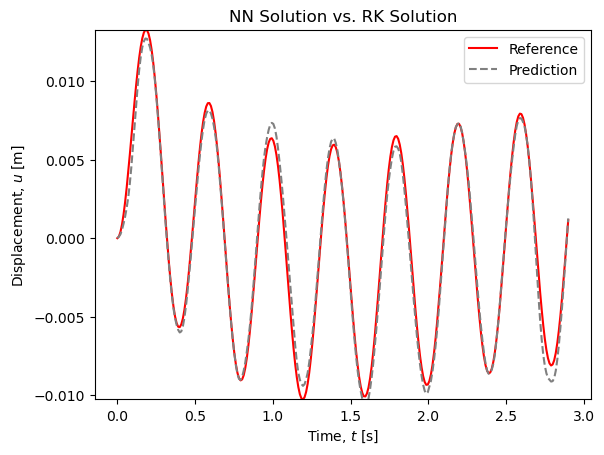

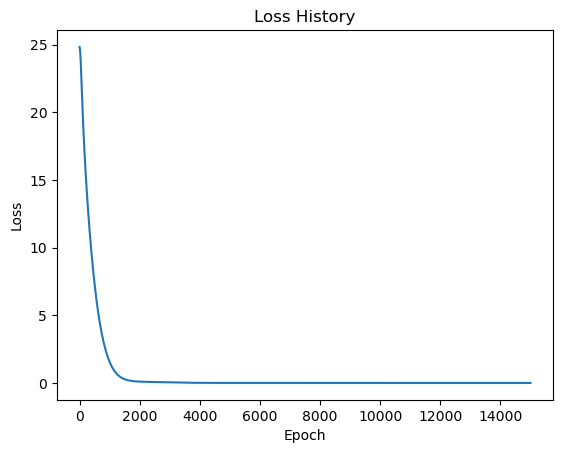

In [6]:
model, z, zpred, losses = perform_training(1e-4, num_epochs=15_000, num_examples=50_000, hidden_features=100, hidden_layers=1)

fn = "outputs"
os.makedirs(fn, exist_ok=True)

# Plot output
plt.figure()
plt.title("NN Solution vs. RK Solution")
plt.xlabel("Time, $t$ [s]")
plt.ylabel("Displacement, $u$ [m]")
plt.plot(t.cpu(), z.cpu()[:, 0], color="red", label="Reference")
plt.plot(
    t.cpu(),
    zpred[:, 0].detach().cpu(),
    color="gray",
    linestyle="--",
    label="Prediction",
)
plt.ylim(z[:, 0].detach().cpu().min(), z[:, 0].detach().cpu().max())
plt.legend()

results_fn = os.path.join(fn, "results.png")
plt.savefig(results_fn, bbox_inches="tight")

# Plot loss
plt.figure()
plt.title("Loss History")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.plot(losses.detach().cpu())

losshistory_fn = os.path.join(fn, "losshistory.png")
plt.savefig(losshistory_fn, bbox_inches="tight")